In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

In [2]:
import time
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
from scipy.special import jv

In [3]:
Z0=376.73
c0=3e8

In [4]:
eps1=1 #superstrate
eps2=1.7 #substrate
sig1=1j*8e-3
sig2=1j*4e-3
a0=5e-6
w=3e-6
#w=0.5*a0
theta=0
phi=0
M=100
lams=np.linspace(4,10,M)*1e-6
#print(lams)
sig_avg=sig1+(sig2-sig1)*(w/a0)
mu1=1
mu2=1

fd,fx,fy=w/a0,w/a0,w/a0
l0=a0/3**0.5

In [5]:
def JJ(z):
    z=z+1e-8
    return jv(1,z)/z

def ret_fresnel_coeff(S):
    a=len(S)//2
    M11=S[:a,:a]
    M12=S[:a,a:]
    M21=S[a:,:a]
    M22=S[a:,a:]
    M22_inv=np.linalg.inv(M22)
    B=np.zeros(np.shape(S),dtype=complex)
    B[:a,:a]=M11-M12@M22_inv@M21
    B[:a,a:]=M22_inv@M12
    B[a:,:a]=M22_inv
    B[a:,a:]=-M22_inv@M21
    return B

def plot_spectrum(TT,lam_list,kx_list,title,param='',save=False,cmap='afmhot'):
    f_list=c0/lam_list[::-1]
    N_lam=len(lam_list)
    N_kx=len(kx_list)
    fig, ax = plt.subplots(figsize=(16,7))
    cax = make_axes_locatable(ax).append_axes('right', size='5%', pad=0.05)        
    im1=ax.imshow(TT,origin='lower',cmap=cmap)
    ax.set_ylabel('$f(x10^{12}Hz)$',fontsize=22)
    ax.set_xlabel('$k_x/\\frac{\pi}{a_0}$',fontsize=22)
    #fig.colorbar(im1, cax=cax, orientation='vertical',label='$ln(det(T))$',labelsize=21)
    fig.colorbar(im1, cax=cax, orientation='vertical').set_label(label='$ln(det(T))$',size=22)

    MM=10
    ax.set_title(title,fontsize=22)
    ax.set_yticks(np.arange(0,N_lam,N_lam//MM))
    ax.set_yticklabels(np.round(f_list[::N_lam//MM]*1e-12,2))
    ax.set_xticks(np.arange(0,N_kx,N_kx//MM))
    ax.set_xticklabels(np.round(np.linspace(-1,1,MM+1),2))
    ax.grid(True,alpha=0.5,ls=':',lw=0.5,c='k')
    if save:plt.savefig('plots\{0}_{1}.png'.format(title,param), bbox_inches='tight')
    plt.show()
    
def reciprocal_lattice(N,theta,theta1=0):
    d_a=np.array([np.cos(theta1),np.sin(theta1)])
    d_b=np.array([np.cos(theta),np.sin(theta)])
    ff=np.cross(d_a,d_b)
    d_a=(2*np.pi/a0)*d_a.reshape(2,1)/ff
    d_b=(2*np.pi/a0)*d_b.reshape(2,1)/ff
    n_list=np.arange(-N,N+1)
    n_ab,n_ba=np.meshgrid(n_list,n_list)
    n_ab=n_ab.flatten()
    n_ba=n_ba.flatten()
    g_list=n_ab*d_a+n_ba*d_b
    return g_list.T

def moire_reciprocal(N,theta,alpha=0,gamma=1,delta=[0,0]):
    ap=gamma*a0
    delta=np.array(delta).reshape(2,1)
    d_a1=np.array([1,0])
    d_a2=np.array([np.cos(theta),np.sin(theta)])
    ff=np.cross(d_a,d_b)
    d_a1=(2*np.pi/a0)*d_a1.reshape(2,1)/ff
    d_a2=(2*np.pi/a0)*d_a2.reshape(2,1)/ff
    d_b1=(2*np.pi/ap)*np.array([np.cos(alpha),np.sin(alpha)]).reshape(2,1)/ff
    d_b2=(2*np.pi/ap)*np.array([np.cos(theta+alpha),np.sin(theta+alpha)]).reshape(2,1)/ff
    d_b1+=(2*np.pi/ap)*delta/ff
    d_b2+=(2*np.pi/ap)*delta/ff
    
    n1,n2=np.meshgrid(np.arange(-N[0],N[0]+1),np.arange(-N[1],N[1]+1))
    n11,n12=np.meshgrid(n1.flatten(),n1.flatten())
    n21,n22=np.meshgrid(n2.flatten(),n2.flatten())
    g_list=n11.flatten()*d_a1+n12.flatten()*d_a2+n21.flatten()*d_b1+n22.flatten()*d_b2
    return g_list.T

def S_translation(abs_kxy,k0,d,eps):
    if d==0:
        return np.eye(2*len(abs_kxy))
    else:
        kz=np.lib.scimath.sqrt(eps*k0**2-abs_kxy)
        S=np.diag(list(np.exp(1j*d*kz))+list(np.exp(-1j*d*kz)))
    return S

def Scatter_Mat(abs_kxy,k0,eps1,eps2,sig):
    M=len(abs_kxy)
    k1z=np.lib.scimath.sqrt(eps1*k0**2-abs_kxy)
    k2z=np.lib.scimath.sqrt(eps2*k0**2-abs_kxy)
    n_scat=np.diag((eps1/eps2)*(k2z/k1z))
    sig=(Z0/(eps2*k0))*(k2z+np.zeros((len(k2z),1)))*sig
    S=np.zeros((2*M,2*M),dtype=complex)
    S[:M,:M]=(np.eye(M)+n_scat+sig)/2
    S[M:,:M]=(np.eye(M)-n_scat-sig)/2
    S[:M,M:]=(np.eye(M)-n_scat+sig)/2
    S[M:,M:]=(np.eye(M)+n_scat-sig)/2
    return S

def transmission0(S):
    B=ret_fresnel_coeff(S)
    MM=np.shape(S)[0]//2
    I=np.zeros((2*MM,1))
    I[(MM-1)//2]=1
    fres=B@I
    T_0=np.sum(fres)
    #T_0=fres[(MM-1)//2]
    #R_0=fres[(MM-1)//2+MM]
    return T_0


In [6]:
def graphene_phase(kx_list,ky_list,lam,N,eps1,eps2):
    TT=np.zeros((len(ky_list),len(kx_list)))
    k0=2*np.pi/lam

    g_list=reciprocal_lattice(N,np.pi/2,np.pi/3+np.pi/2)
    M=np.shape(g_list)[0]
    g_ab=g_list.reshape(1,M,2)
    g_ab=(g_ab-np.transpose(g_ab,(1,0,2))) 
    sig=np.eye(M)*sig1+(sig2-sig1)*(np.pi*fd**2/2)*JJ((w/2)*np.sum(g_ab**2,axis=2)**0.5)*2*np.cos(g_ab[:,:,1]*l0/2)
    
    for i_kx,kx in enumerate(kx_list):
        for i_ky,ky in enumerate(ky_list):
            kxy0=np.array([kx,ky]).reshape(1,2)
            abs_kxy=np.sum((kxy0+g_list)**2,axis=1)

            S=Scatter_Mat(abs_kxy,k0,eps1,eps2,sig)
            #TT[i_ky][i_kx]=(np.abs(transmission0(S)))
            #TT[i_ky][i_kx]=(np.abs(np.linalg.det((S))))
            TT[i_ky][i_kx]=(np.abs(np.linalg.det(ret_fresnel_coeff(S))))
    return TT

def S_sheet_graphene(kx_list,ky_list,lam_list,N,eps1,eps2):
    TT=np.zeros((len(lam_list),len(kx_list)))
    k0_list=2*np.pi/lam_list

    g_list=reciprocal_lattice(N,0,np.pi/3)
    M=np.shape(g_list)[0]
    g_ab=g_list.reshape(1,M,2)
    g_ab=(g_ab-np.transpose(g_ab,(1,0,2))) 
    sig=np.eye(M)*sig1+(sig2-sig1)*(np.pi*fd**2/2)*JJ((w/2)*np.sum(g_ab**2,axis=2)**0.5)*2*np.cos(g_ab[:,:,1]*l0/2)
    
    for p in range(len(kx_list)):
        kxy0=np.array([kx_list[p],ky_list[p]]).reshape(1,2)
        abs_kxy=np.sum((kxy0+g_list)**2,axis=1)
        for i_k0,k0 in enumerate(k0_list):
            S=Scatter_Mat(abs_kxy,k0,eps1,eps2,sig)
            TT[i_k0][p]=(np.abs(transmission0(S)))
            #TT[i_k0][p]=(np.abs(np.linalg.det((S))))
            #TT[i_k0][p]=(np.abs(np.linalg.det(ret_fresnel_coeff(S))))
    return TT

def S_slab_graphene(kx_list,ky_list,lam_list,N,eps1,eps2,d):
    TT=np.zeros((len(lam_list),len(kx_list)))
    k0_list=2*np.pi/lam_list
    
    g_list=reciprocal_lattice(N,0,np.pi/3)
    M=np.shape(g_list)[0]
    g_ab=g_list.reshape(1,(2*N+1)**2,2)
    g_ab=(g_ab-np.transpose(g_ab,(1,0,2))) 
    sig=np.eye(M)*sig1+(sig2-sig1)*(np.pi*fd**2/2)*JJ((w/2)*np.sum(g_ab**2,axis=2)**0.5)*2*np.cos(g_ab[:,:,1]*l0/2)
    
    for p in range(len(kx_list)):
        kxy0=np.array([kx_list[p],ky_list[p]]).reshape(1,2)
        abs_kxy=np.sum((kxy0+g_list)**2,axis=1)
        for i_k0,k0 in enumerate(k0_list):
            S=Scatter_Mat(abs_kxy,k0,eps1,eps2,sig)@S_translation(abs_kxy,k0,d,eps2)@Scatter_Mat(abs_kxy,k0,eps2,eps1,sig)
            TT[i_k0][p]=(np.abs(transmission0(S)))
            #TT[i_k0][p]=(np.abs(np.linalg.det((S))))
            #TT[i_k0][p]=(np.abs(np.linalg.det(ret_fresnel_coeff(S))))
    return TT

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide


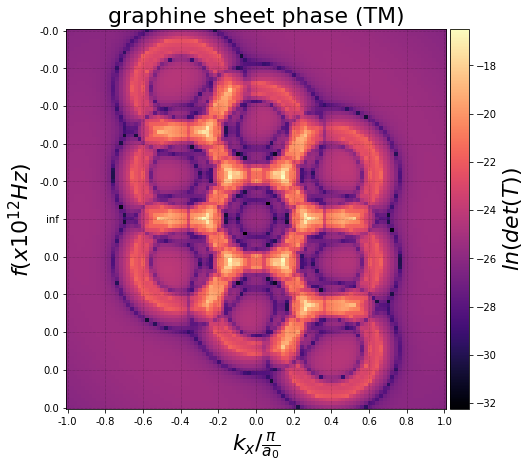

7.28125


In [12]:
N=1
N_kx=101
N_ky=N_kx
kx_list=5*np.linspace(-1,1,N_kx)*(np.pi/a0)
ky_list=5*np.linspace(-1,1,N_kx)*(np.pi/a0)
lam=1e-5
start=time.process_time()
TT=graphene_phase(kx_list,ky_list,lam,N,eps1,eps2)
plot_spectrum(np.log(TT),ky_list,kx_list,'graphine sheet phase (TM)','N='+str(N),False,'magma')
print(time.process_time()-start)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide


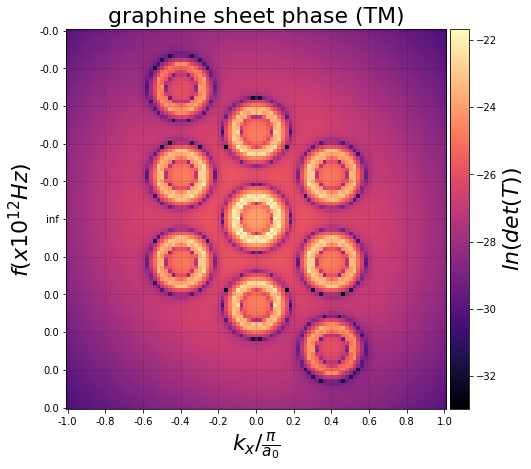

7.40625


In [22]:
N=1
N_kx=101
N_ky=N_kx
kx_list=5*np.linspace(-1,1,N_kx)*(np.pi/a0)
ky_list=5*np.linspace(-1,1,N_kx)*(np.pi/a0)
lam=2e-5
start=time.process_time()
TT=graphene_phase(kx_list,ky_list,lam,N,eps1,eps2)
plot_spectrum(np.log(TT),ky_list,kx_list,'graphine sheet phase (TM)','N='+str(N),False,'magma')
print(time.process_time()-start)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide


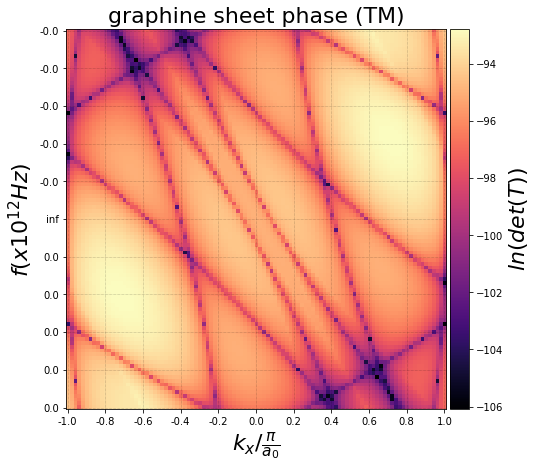

139.625


In [13]:
N=3
N_kx=101
N_ky=N_kx
kx_list=np.linspace(-1,1,N_kx)*(np.pi/a0)
ky_list=np.linspace(-1,1,N_kx)*(np.pi/a0)
lam=1e-6
start=time.process_time()
TT=graphene_phase(kx_list,ky_list,lam,N,eps1,eps2)
plot_spectrum(np.log(TT),ky_list,kx_list,'graphine sheet phase (TM)','N='+str(N),False,'magma')
print(time.process_time()-start)

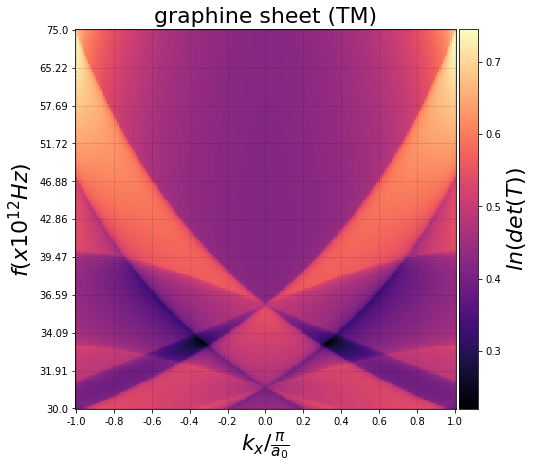

819.34375


In [48]:
N=4
N_kx=201
N_lam=N_kx
kx_list=np.linspace(-1,1,N_kx)*(np.pi/a0)
ky_list=0*np.linspace(-1,1,N_kx)*(np.pi/a0)
lam_list=np.linspace(4,10,N_lam)*1e-6
start=time.process_time()
TT=S_sheet_graphene(kx_list,ky_list,lam_list,N,eps1,eps2)
plot_spectrum(np.log(TT),lam_list,kx_list,'graphine sheet (TM)','N='+str(N),False,'magma')
print(time.process_time()-start)

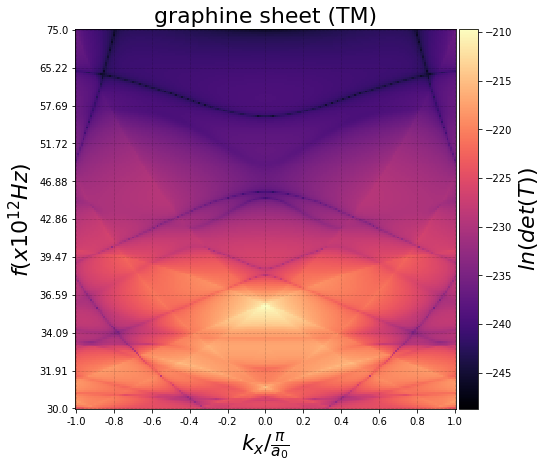

1022.265625


In [20]:
N=4
N_kx=201
N_lam=N_kx
kx_list=np.linspace(-1,1,N_kx)*(np.pi/a0)
ky_list=0*np.linspace(-1,1,N_kx)*(np.pi/a0)
lam_list=np.linspace(4,10,N_lam)*1e-6
start=time.process_time()
TT=S_sheet_graphene(kx_list,ky_list,lam_list,N,eps1,eps2)
plot_spectrum(np.log(TT),lam_list,kx_list,'graphine sheet (TM)','N='+str(N),True,'magma')
print(time.process_time()-start)

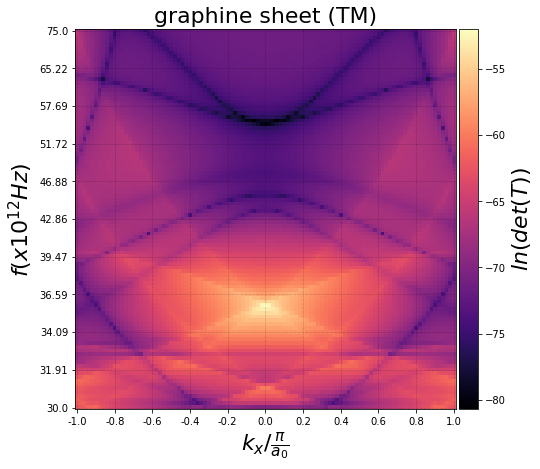

64.890625


In [19]:
N=2
N_kx=101
N_lam=N_kx
kx_list=np.linspace(-1,1,N_kx)*(np.pi/a0)
ky_list=0*np.linspace(-1,1,N_kx)*(np.pi/a0)
lam_list=np.linspace(4,10,N_lam)*1e-6
start=time.process_time()
TT=S_sheet_graphene(kx_list,ky_list,lam_list,N,eps1,eps2)
plot_spectrum(np.log(TT),lam_list,kx_list,'graphine sheet (TM)','N='+str(N),True,'magma')
print(time.process_time()-start)

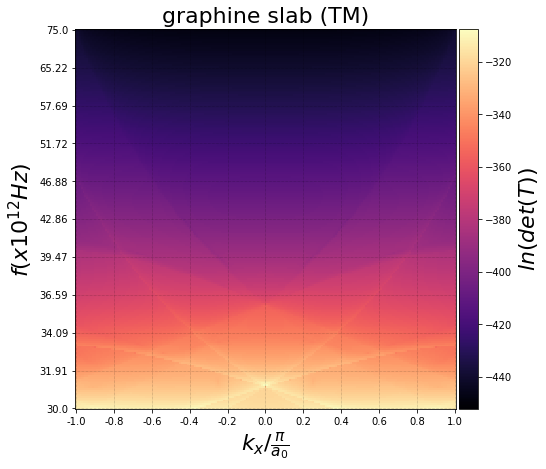

924.125


In [21]:
N=3
d=1e-1*a0
N_kx=201
N_lam=N_kx
kx_list=np.linspace(-1,1,N_kx)*(np.pi/a0)
ky_list=0*np.linspace(-1,1,N_kx)*(np.pi/a0)
lam_list=np.linspace(4,10,N_lam)*1e-6
start=time.process_time()
TT=S_slab_graphene(kx_list,ky_list,lam_list,N,eps1,eps2,d)
plot_spectrum(np.log(TT),lam_list,kx_list,'graphine slab (TM)','N='+str(N),True,'magma')
print(time.process_time()-start)

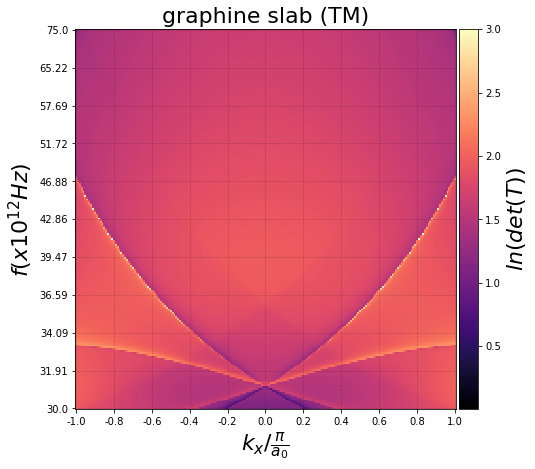

1955.3125


In [33]:
N=4
d=1e-1*a0
N_kx=201
N_lam=N_kx
kx_list=np.linspace(-1,1,N_kx)*(np.pi/a0)
ky_list=0*np.linspace(-1,1,N_kx)*(np.pi/a0)
lam_list=np.linspace(4,10,N_lam)*1e-6
start=time.process_time()
TT=S_slab_graphene(kx_list,ky_list,lam_list,N,eps1,eps2,d)
plot_spectrum((TT),lam_list,kx_list,'graphine slab (TM)','N='+str(N),False,'magma')
print(time.process_time()-start)

In [57]:
def TBG_wrt_alpha(lam_list,alpha_list,N,eps1,eps2):
    M=(2*N+1)**2
    TT=np.zeros((len(lam_list),len(alpha_list)))
    k0_list=2*np.pi/lam_list
    gamma=1
    delta=0
    a1=gamma*a0
    d=1e-1*a0
    h=0

    gg=reciprocal_lattice(N,np.pi/3).reshape(1,M,2)
    gg=(gg-np.transpose(gg,(1,0,2)))
    sig_a=np.eye(M)*sig1+(sig2-sig1)*(np.pi*fd**2/2)*JJ((w/2)*np.sum(gg**2,axis=2)**0.5)*2*np.cos(gg[:,:,1]*l0/2)
    sig_a=np.kron(np.eye(M),sig_a)
    sig_b=np.eye(M)*sig1+(sig2-sig1)*(np.pi*fd**2/2)*JJ((w/2)*np.sum(gg**2,axis=2)**0.5)*2*np.cos(gg[:,:,1]*l0/2)*np.exp(1j*gg[:,:,0]*delta*a0)
    sig_b=np.kron(sig_b,np.eye(M))

    kxy0=np.array([0,0]).reshape(1,2)
    
    for i_alpha,alpha in enumerate(alpha_list):
        g_list=moire_reciprocal([N,N],np.pi/3,alpha)
        abs_kxy=np.sum((kxy0+g_list)**2,axis=1)
        for i_k0,k0 in enumerate(k0_list):
    #             Slab_a=S_moire(eps2,eps3,abs_kxy,sig_a,k0)@S_translate(eps2,abs_kxy,d,k0)@S_moire(eps1,eps2,abs_kxy,sig_a,k0)
    #             Slab_b=S_moire(eps4,eps5,abs_kxy,sig_b,k0)@S_translate(eps4,abs_kxy,d,k0)@S_moire(eps3,eps4,abs_kxy,sig_b,k0)
    #             S=Slab_b@S_translate(eps3,abs_kxy,h,k0)@Slab_a
            S=Scatter_Mat(abs_kxy,k0,eps1,eps2,sig_b)@S_translation(abs_kxy,k0,d,eps2)@Scatter_Mat(abs_kxy,k0,eps2,eps1,sig_a)
            TT[i_k0][i_alpha]=(np.abs(transmission0(S)))
            #TT[i_k0][i_alpha]=(np.abs(np.linalg.det(ret_fresnel_coeff(S))))
    return TT

def TBG_wrt_theta(lam_list,theta_list,N,eps1,eps2):
   
    M=(2*N+1)**2
    TT=np.zeros((len(lam_list),len(theta_list)))
    k0_list=2*np.pi/lam_list
    gamma=1
    delta=[0,0]
    a1=gamma*a0
    d=1e-1*a0
    h=0

    gga=reciprocal_lattice(N[0],np.pi/3).reshape(1,M[0],2)
    gga=(gga-np.transpose(gga,(1,0,2)))
    ggb=reciprocal_lattice(N[1],np.pi/3).reshape(1,M[1],2)
    ggb=(ggb-np.transpose(ggb,(1,0,2)))
    
    sig_a=np.eye(M[0])*sig1+(sig2-sig1)*(np.pi*fd**2/2)*JJ((w/2)*np.sum(gga**2,axis=2)**0.5)*2*np.cos(gga[:,:,1]*l0/2)
    sig_a=np.kron(np.eye(M[1]),sig_a)
    sig_b=np.eye(M[1])*sig1+(sig2-sig1)*(np.pi*fd**2/2)*JJ((w/2)*np.sum(ggb**2,axis=2)**0.5)*2*np.cos(ggb[:,:,1]*l0/2)*np.exp(1j*np.dot(ggb,delta)*a0)
    sig_b=np.kron(sig_b,np.eye(M[0]))

    
    g_list=moire_reciprocal(N,np.pi/3,0)
    for i_theta,theta in enumerate(theta_list):
        kxy0=(2/3**0.5)*(2*np.pi/a0)*np.array([np.sin(theta),0]).reshape(1,2)
        abs_kxy=np.sum((kxy0+g_list)**2,axis=1)
        for i_k0,k0 in enumerate(k0_list):                 
    #             Slab_a=S_moire(eps2,eps3,abs_kxy,sig_a,k0)@S_translate(eps2,abs_kxy,d,k0)@S_moire(eps1,eps2,abs_kxy,sig_a,k0)
    #             Slab_b=S_moire(eps4,eps5,abs_kxy,sig_b,k0)@S_translate(eps4,abs_kxy,d,k0)@S_moire(eps3,eps4,abs_kxy,sig_b,k0)
    #             S=Slab_b@S_translate(eps3,abs_kxy,h,k0)@Slab_a
            S=Scatter_Mat(abs_kxy,k0,eps1,eps2,sig_b)@S_translation(abs_kxy,k0,d,eps2)@Scatter_Mat(abs_kxy,k0,eps2,eps1,sig_a)
            TT[i_k0][i_theta]=(np.abs(transmission0(S)))
            #TT[i_k0][i_theta]=(np.abs(np.linalg.det(ret_fresnel_coeff(S))))
    return TT


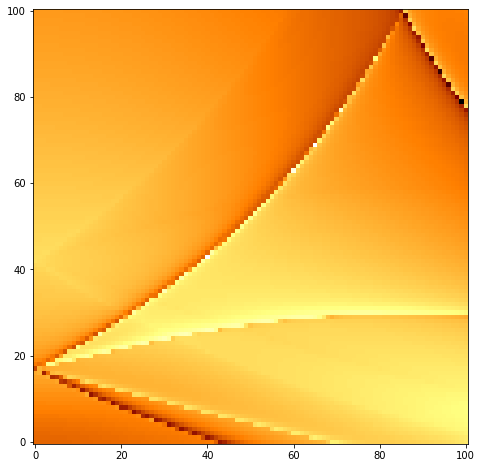

In [64]:
N=np.array([3,0])

N_theta=101
N_lam=N_theta
theta_list=np.linspace(0,1,N_theta)*np.pi/6
lam_list=np.linspace(4,10,N_lam)*1e-6
TT=TBG_wrt_theta(lam_list,theta_list,N,eps1,eps2)
plt.figure(figsize=(8,8))
plt.imshow((TT),cmap='afmhot',origin='lower')
plt.show()

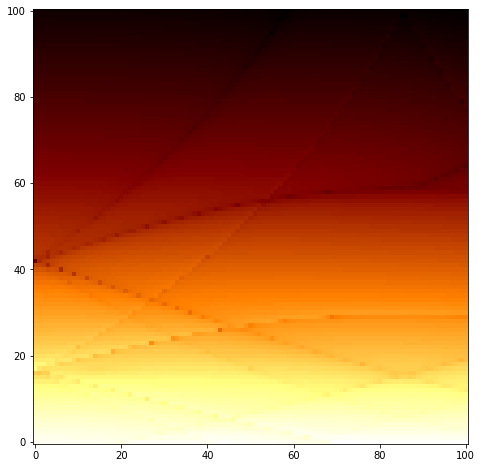

In [68]:
N=np.array([3,0])

N_theta=101
N_lam=N_theta
theta_list=np.linspace(0,1,N_alpha)*np.pi/6
lam_list=np.linspace(4,10,N_lam)*1e-6
TT=TBG_wrt_theta(lam_list,theta_list,N,eps1,eps2)
plt.figure(figsize=(8,8))
plt.imshow(np.log(TT),cmap='afmhot',origin='lower')
plt.show()

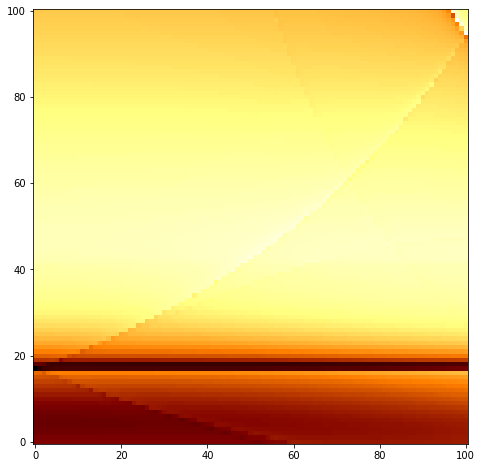

In [65]:
N=1
N_alpha=101
N_lam=N_alpha
alpha_list=np.linspace(0,1,N_alpha)*np.pi/6
lam_list=np.linspace(4,10,N_lam)*1e-6
TT=TBG_wrt_alpha(lam_list,alpha_list,N,eps1,eps2)
plt.figure(figsize=(8,8))
plt.imshow((TT),cmap='afmhot',origin='lower')
plt.show()

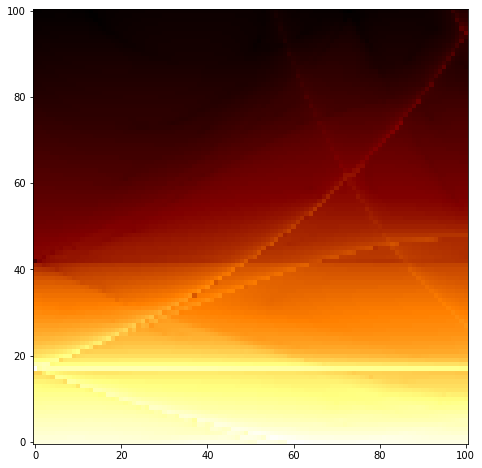

In [24]:
N=1
N_alpha=101
N_lam=N_alpha
alpha_list=np.linspace(0,1,N_alpha)*np.pi/6
lam_list=np.linspace(4,10,N_lam)*1e-6
TT=TBG_wrt_alpha(lam_list,alpha_list,N,eps1,eps2)
plt.figure(figsize=(8,8))
plt.imshow(np.log(TT),cmap='afmhot',origin='lower')
plt.show()

In [61]:
def TBG_wrt_kx(lam_list,kx_list,ky_list,N,eps1,eps2,alpha=0):
    M=(2*N+1)**2
    TT=np.zeros((len(lam_list),len(kx_list)))
    k0_list=2*np.pi/lam_list
    gamma=1
    delta=0
    a1=gamma*a0
    d=1e-1*a0
    h=0

    gg=reciprocal_lattice(N,np.pi/3).reshape(1,M,2)
    gg=(gg-np.transpose(gg,(1,0,2)))
    sig_a=np.eye(M)*sig1+(sig2-sig1)*(np.pi*fd**2/2)*JJ((w/2)*np.sum(gg**2,axis=2)**0.5)*2*np.cos(gg[:,:,1]*l0/2)
    sig_a=np.kron(np.eye(M),sig_a)
    sig_b=np.eye(M)*sig1+(sig2-sig1)*(np.pi*fd**2/2)*JJ((w/2)*np.sum(gg**2,axis=2)**0.5)*2*np.cos(gg[:,:,1]*l0/2)*np.exp(1j*gg[:,:,0]*delta*a0)
    sig_b=np.kron(sig_b,np.eye(M))

    
    g_list=moire_reciprocal([N,N],np.pi/3,alpha)
    for p in range(len(kx_list)):
        kxy0=np.array([kx_list[p],ky_list[p]]).reshape(1,2)
        abs_kxy=np.sum((kxy0+g_list)**2,axis=1)
        for i_k0,k0 in enumerate(k0_list):
    #             Slab_a=S_moire(eps2,eps3,abs_kxy,sig_a,k0)@S_translate(eps2,abs_kxy,d,k0)@S_moire(eps1,eps2,abs_kxy,sig_a,k0)
    #             Slab_b=S_moire(eps4,eps5,abs_kxy,sig_b,k0)@S_translate(eps4,abs_kxy,d,k0)@S_moire(eps3,eps4,abs_kxy,sig_b,k0)
    #             S=Slab_b@S_translate(eps3,abs_kxy,h,k0)@Slab_a
            S=Scatter_Mat(abs_kxy,k0,eps1,eps2,sig_b)@S_translation(abs_kxy,k0,d,eps2)@Scatter_Mat(abs_kxy,k0,eps2,eps1,sig_a)
            TT[i_k0][p]=(np.abs(transmission0(S)))
            #TT[i_k0][p]=(np.abs(np.linalg.det(ret_fresnel_coeff(S))))
    return TT


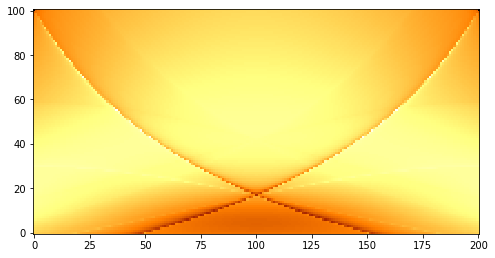

In [62]:
N=1
alpha=0
N_kx=101
N_lam=N_kx
kx_list=np.linspace(-1,1,N_kx)*(np.pi/a0)
ky_list=0*np.linspace(-1,1,N_kx)*(np.pi/a0)
lam_list=np.linspace(4,10,N_lam)*1e-6
TT=TBG_wrt_kx(lam_list,kx_list,ky_list,N,eps1,eps2,alpha)
plt.figure(figsize=(8,8))
plt.imshow((TT),cmap='afmhot',origin='lower')
plt.show()

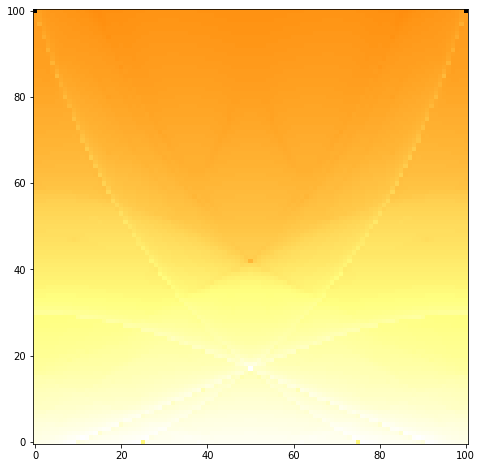

In [26]:
N=1
alpha=0
N_alpha=101
N_lam=N_alpha
kx_list=np.linspace(-1,1,N_kx)*(np.pi/a0)
ky_list=0*np.linspace(-1,1,N_kx)*(np.pi/a0)
lam_list=np.linspace(4,10,N_lam)*1e-6
TT=TBG_wrt_kx(lam_list,kx_list,ky_list,N,eps1,eps2,alpha)
plt.figure(figsize=(8,8))
plt.imshow(np.log(TT),cmap='afmhot',origin='lower')
plt.show()

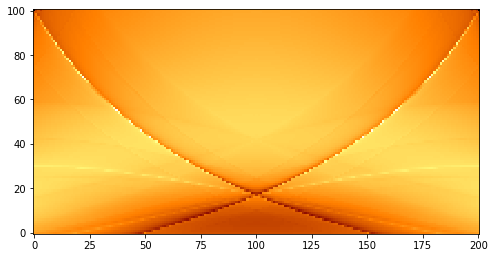

In [63]:
N=1
alpha=0.1
N_kx=101
N_lam=N_kx
kx_list=np.linspace(-1,1,N_kx)*(np.pi/a0)
ky_list=0*np.linspace(-1,1,N_kx)*(np.pi/a0)
lam_list=np.linspace(4,10,N_lam)*1e-6
TT=TBG_wrt_kx(lam_list,kx_list,ky_list,N,eps1,eps2,alpha)
plt.figure(figsize=(8,8))
plt.imshow((TT),cmap='afmhot',origin='lower')
plt.show()

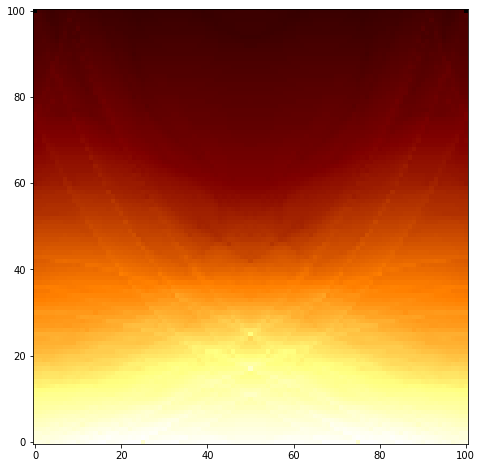

In [27]:
N=1
alpha=0.1
N_alpha=101
N_lam=N_alpha
kx_list=np.linspace(-1,1,N_kx)*(np.pi/a0)
ky_list=0*np.linspace(-1,1,N_kx)*(np.pi/a0)
lam_list=np.linspace(4,10,N_lam)*1e-6
TT=TBG_wrt_kx(lam_list,kx_list,ky_list,N,eps1,eps2,alpha)
plt.figure(figsize=(8,8))
plt.imshow(np.log(TT),cmap='afmhot',origin='lower')
plt.show()